In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

In [4]:
data = pd.read_csv('EuropeCovid2_data.csv', index_col=0)

In [5]:
data

,id,country,date,cases,deaths,schools_universities,self_isolating_if_ill,public_events,lockdown,social_distancing_encouraged,pop
1,AT,Austria,2020-01-03,0.0,0.0,0,0,0,0,0,NaN
2,AT,Austria,2020-01-04,0.0,0.0,0,0,0,0,0,NaN
3,AT,Austria,2020-01-05,0.0,0.0,0,0,0,0,0,NaN
4,AT,Austria,2020-01-06,0.0,0.0,0,0,0,0,0,NaN
5,AT,Austria,2020-01-07,0.0,0.0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1976,GB,United_Kingdom,2020-06-26,778.0,99.0,1,1,1,1,1,NaN
1977,GB,United_Kingdom,2020-06-27,721.0,77.0,1,1,1,1,1,NaN
1978,GB,United_Kingdom,2020-06-28,671.0,40.0,1,1,1,1,1,NaN
1979,GB,United_Kingdom,2020-06-29,649.0,31.0,1,1,1,1,1,NaN


# 2. EDA

In [6]:
data['id'].value_counts()

AT    180
BE    180
DK    180
FR    180
DE    180
IT    180
NO    180
ES    180
SE    180
CH    180
GB    180
Name: id, dtype: int64

In [7]:
region = 'GB'
data_r = data[data.id == region]
Y_raw = data_r.deaths.to_numpy()
POI = np.cumsum(Y_raw) > 0

In [8]:
# Y 
Y_data = Y_raw[POI]
I_data = data_r.cases[POI].to_numpy()

In [9]:
T = Y_data.shape[0]
T0 = 20
alpha = 1
K = 6.5

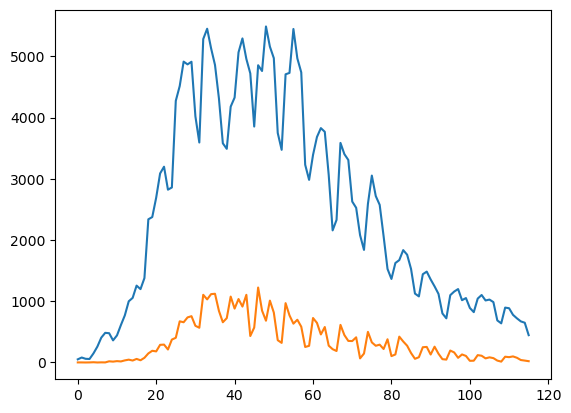

In [10]:
plt.plot(alpha*I_data)
plt.plot(Y_data)

In [11]:
GPi = np.load('EuropeCovid2_GPi.npz')

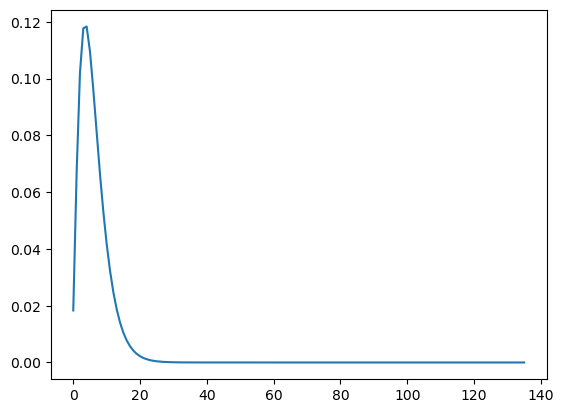

In [12]:
# g
g = np.zeros(T+T0)
g[:GPi['g'].shape[0]] = GPi['g']
plt.plot(g)

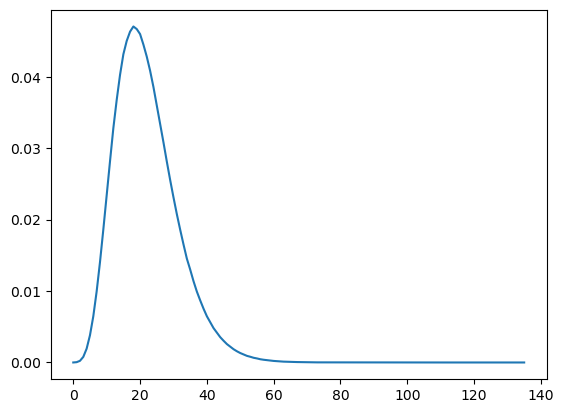

In [13]:
# pi
pi = np.zeros(T+T0)
pi[:GPi['pi'].shape[0]] = GPi['pi']
plt.plot(pi)

In [14]:
# A
d = 2
A = np.zeros([T+T0, d])

In [15]:
A[:,0] = np.full(T+T0, 1)
A[T0:,1] = data_r.lockdown[POI].to_numpy()

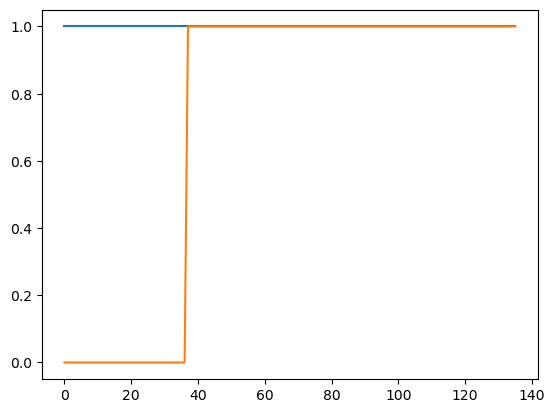

In [16]:
plt.plot(A)

# 3. fit by EM algorithm

In [17]:
def NBLL(y, m, r):
    y = int(y)
    return (np.sum(np.log(1+(r-1)/(np.arange(y)+1))) 
            + r * np.log(r/(r+m)) 
            + y * np.log(m/(r+m)))

In [18]:
def dNBLLdr(y, m, r):
    y = int(y)
    return (np.sum(1/(np.arange(y)+r)) + np.log(r/(r+m)) + (m-y)/(r+m))

In [19]:
def d2NBLLdr2(y, m, r):
    y = int(y)
    return (-np.sum(1/(np.arange(y)+r)**2) + 1/r + 1/(r+m) - (m-y)/(r+m)**2)

In [20]:
def fit(obs, rinit, minit_0, binit,
        n_iter=3000, history=False, verbose=False, step_size=0.1):
    
    rhat = rinit
    mhat_0 = minit_0
    bhat=binit
    ss=np.inf
        
    if history:
        rhs = np.zeros(n_iter)
        mhs_0 = np.zeros(n_iter)
        bhs = np.zeros([n_iter, d])
        lls = np.zeros(n_iter)
        
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = - K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    ll = np.sum([NBLL(y, m, rhat) for y, m in zip(obs, EY)])
    
    if verbose:
        print("Before EM, ll: %f"%ll)
    
    for i in np.arange(n_iter):
        start_iter = time.time()

        # derivatives
        d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        d2G = d2Rh[...,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        
        d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
        d2EY = mhat_0 * (Pi_inv_ImG @ (
            d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
            + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
            + d2G @ inv_ImG[:,:1]))[...,0]
        
        # first derivative
        dldEY = obs/EY - (rhat+obs)/(rhat+EY)
        
        dldr = np.sum([dNBLLdr(y, m, rhat) for y, m in zip(obs, EY)])
        dldm = np.sum(dldEY * Pi_inv_ImG[:,0])
        dldb = np.sum(dldEY * d1EY, 1)

        dldth = np.concatenate([[dldr, dldm], dldb])
        
        # second deivative
        d2ldEY2 = - obs/EY**2 + (rhat+obs)/(rhat+EY)**2
        d2ldrdEY = - 1/(rhat+EY) + (rhat+obs)/(rhat+EY)**2

        d2ldr2 = np.sum([d2NBLLdr2(y, m, rhat) for y, m in zip(obs, EY)])
        d2ldm2 = np.sum(d2ldEY2 * Pi_inv_ImG[:,0]**2)
        d2ldb2 = np.sum(d2ldEY2 * d1EY * d1EY[:,None,:], 2) \
               + np.sum(dldEY * d2EY, 2)

        d2ldrdm = np.sum(d2ldrdEY * Pi_inv_ImG[:,0])
        d2ldrdb = np.sum(d2ldrdEY * d1EY, 1)
        d2ldmdb = np.sum(d2ldEY2 * Pi_inv_ImG[:,0] * d1EY, 1) \
                + np.sum(dldEY * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0], 1)
        
        d2ldrm2 = np.array([[d2ldr2, d2ldrdm],
                            [d2ldrdm, d2ldm2]])
        d2ldrmdb = np.stack([d2ldrdb, 
                             d2ldmdb])
        
        d2ldth2 = np.block([[d2ldrm2, d2ldrmdb],
                            [d2ldrmdb.T, d2ldb2]])
        
        # Newton's method
        u, v = la.eig(-d2ldth2)
        # dth = np.real(((v/u) @ v.T) @ dldth)
        dth = np.real(((v/np.maximum(u,np.max(u)/1000)) @ v.T) @ dldth)
        ss = np.min([1, 1/np.sqrt(np.sum(dth**2))])
        
        rhat = rhat + ss * dth[0]
        mhat_0 = mhat_0 + ss * dth[1]
        bhat = bhat + ss * dth[2:]
        
        for t in np.arange(T+T0):
            o = np.exp(bhat @ A[t])
            p = 1 / (1 + o)
            q = o / (1 + o)

            Rhat[t] = K * p
            d1Rh[:,t] = - K * p * q * A[t]
            d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

        Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
        G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        inv_ImG = la.inv(np.eye(T+T0)-G)
        Pi_inv_ImG = Pi @ inv_ImG
    
        EY = mhat_0 * Pi_inv_ImG[:,0]
        ll = np.sum([NBLL(y, m, rhat) for y, m in zip(obs, EY)])
    
        if history:
            rhs[i] = rhat
            mhs_0[i] = mhat_0
            bhs[i] = bhat
            lls[i] = ll
        
        if verbose:
            print("%d-th iteration finished, ll: %f, lapse: %.3fsec."
                  %(i+1, ll, time.time()-start_iter))
            
    if history:
        return rhs, mhs_0, bhs
    else:
        return rhat, mhat_0, bhat

In [21]:
rmle = 5.2
mmle_0 = 2.5
bmle = [-0.35, 2.5]

In [22]:
rhs, mhs_0, bhs =\
    fit(Y_data, rmle, mmle_0, bmle, 
        history=True, verbose=True, n_iter=10000, step_size=1)

Before EM, ll: -690.767284
1-th iteration finished, ll: -665.805301, lapse: 0.008sec.
2-th iteration finished, ll: -665.466665, lapse: 0.016sec.
3-th iteration finished, ll: -665.465798, lapse: 0.015sec.
4-th iteration finished, ll: -665.465127, lapse: 0.034sec.
5-th iteration finished, ll: -665.464526, lapse: 0.008sec.
6-th iteration finished, ll: -665.463988, lapse: 0.007sec.
7-th iteration finished, ll: -665.463507, lapse: 0.007sec.
8-th iteration finished, ll: -665.463076, lapse: 0.011sec.
9-th iteration finished, ll: -665.462690, lapse: 0.008sec.
10-th iteration finished, ll: -665.462345, lapse: 0.008sec.
11-th iteration finished, ll: -665.462037, lapse: 0.008sec.
12-th iteration finished, ll: -665.461761, lapse: 0.008sec.
13-th iteration finished, ll: -665.461514, lapse: 0.010sec.
14-th iteration finished, ll: -665.461294, lapse: 0.010sec.
15-th iteration finished, ll: -665.461097, lapse: 0.011sec.
16-th iteration finished, ll: -665.460921, lapse: 0.010sec.
17-th iteration finish

138-th iteration finished, ll: -665.459450, lapse: 0.012sec.
139-th iteration finished, ll: -665.459450, lapse: 0.018sec.
140-th iteration finished, ll: -665.459450, lapse: 0.010sec.
141-th iteration finished, ll: -665.459450, lapse: 0.016sec.
142-th iteration finished, ll: -665.459450, lapse: 0.010sec.
143-th iteration finished, ll: -665.459450, lapse: 0.010sec.
144-th iteration finished, ll: -665.459450, lapse: 0.013sec.
145-th iteration finished, ll: -665.459450, lapse: 0.015sec.
146-th iteration finished, ll: -665.459450, lapse: 0.010sec.
147-th iteration finished, ll: -665.459450, lapse: 0.010sec.
148-th iteration finished, ll: -665.459450, lapse: 0.010sec.
149-th iteration finished, ll: -665.459450, lapse: 0.011sec.
150-th iteration finished, ll: -665.459450, lapse: 0.017sec.
151-th iteration finished, ll: -665.459450, lapse: 0.010sec.
152-th iteration finished, ll: -665.459450, lapse: 0.010sec.
153-th iteration finished, ll: -665.459450, lapse: 0.036sec.
154-th iteration finishe

284-th iteration finished, ll: -665.459450, lapse: 0.019sec.
285-th iteration finished, ll: -665.459450, lapse: 0.010sec.
286-th iteration finished, ll: -665.459450, lapse: 0.011sec.
287-th iteration finished, ll: -665.459450, lapse: 0.010sec.
288-th iteration finished, ll: -665.459450, lapse: 0.011sec.
289-th iteration finished, ll: -665.459450, lapse: 0.009sec.
290-th iteration finished, ll: -665.459450, lapse: 0.012sec.
291-th iteration finished, ll: -665.459450, lapse: 0.010sec.
292-th iteration finished, ll: -665.459450, lapse: 0.010sec.
293-th iteration finished, ll: -665.459450, lapse: 0.012sec.
294-th iteration finished, ll: -665.459450, lapse: 0.010sec.
295-th iteration finished, ll: -665.459450, lapse: 0.010sec.
296-th iteration finished, ll: -665.459450, lapse: 0.011sec.
297-th iteration finished, ll: -665.459450, lapse: 0.010sec.
298-th iteration finished, ll: -665.459450, lapse: 0.010sec.
299-th iteration finished, ll: -665.459450, lapse: 0.010sec.
300-th iteration finishe

435-th iteration finished, ll: -665.459450, lapse: 0.012sec.
436-th iteration finished, ll: -665.459450, lapse: 0.017sec.
437-th iteration finished, ll: -665.459450, lapse: 0.010sec.
438-th iteration finished, ll: -665.459450, lapse: 0.011sec.
439-th iteration finished, ll: -665.459450, lapse: 0.011sec.
440-th iteration finished, ll: -665.459450, lapse: 0.011sec.
441-th iteration finished, ll: -665.459450, lapse: 0.010sec.
442-th iteration finished, ll: -665.459450, lapse: 0.026sec.
443-th iteration finished, ll: -665.459450, lapse: 0.010sec.
444-th iteration finished, ll: -665.459450, lapse: 0.012sec.
445-th iteration finished, ll: -665.459450, lapse: 0.012sec.
446-th iteration finished, ll: -665.459450, lapse: 0.013sec.
447-th iteration finished, ll: -665.459450, lapse: 0.011sec.
448-th iteration finished, ll: -665.459450, lapse: 0.013sec.
449-th iteration finished, ll: -665.459450, lapse: 0.013sec.
450-th iteration finished, ll: -665.459450, lapse: 0.009sec.
451-th iteration finishe

587-th iteration finished, ll: -665.459450, lapse: 0.017sec.
588-th iteration finished, ll: -665.459450, lapse: 0.012sec.
589-th iteration finished, ll: -665.459450, lapse: 0.011sec.
590-th iteration finished, ll: -665.459450, lapse: 0.010sec.
591-th iteration finished, ll: -665.459450, lapse: 0.010sec.
592-th iteration finished, ll: -665.459450, lapse: 0.011sec.
593-th iteration finished, ll: -665.459450, lapse: 0.011sec.
594-th iteration finished, ll: -665.459450, lapse: 0.014sec.
595-th iteration finished, ll: -665.459450, lapse: 0.010sec.
596-th iteration finished, ll: -665.459450, lapse: 0.010sec.
597-th iteration finished, ll: -665.459450, lapse: 0.010sec.
598-th iteration finished, ll: -665.459450, lapse: 0.009sec.
599-th iteration finished, ll: -665.459450, lapse: 0.010sec.
600-th iteration finished, ll: -665.459450, lapse: 0.010sec.
601-th iteration finished, ll: -665.459450, lapse: 0.011sec.
602-th iteration finished, ll: -665.459450, lapse: 0.011sec.
603-th iteration finishe

725-th iteration finished, ll: -665.459450, lapse: 0.013sec.
726-th iteration finished, ll: -665.459450, lapse: 0.017sec.
727-th iteration finished, ll: -665.459450, lapse: 0.010sec.
728-th iteration finished, ll: -665.459450, lapse: 0.010sec.
729-th iteration finished, ll: -665.459450, lapse: 0.011sec.
730-th iteration finished, ll: -665.459450, lapse: 0.010sec.
731-th iteration finished, ll: -665.459450, lapse: 0.010sec.
732-th iteration finished, ll: -665.459450, lapse: 0.012sec.
733-th iteration finished, ll: -665.459450, lapse: 0.010sec.
734-th iteration finished, ll: -665.459450, lapse: 0.013sec.
735-th iteration finished, ll: -665.459450, lapse: 0.011sec.
736-th iteration finished, ll: -665.459450, lapse: 0.011sec.
737-th iteration finished, ll: -665.459450, lapse: 0.010sec.
738-th iteration finished, ll: -665.459450, lapse: 0.012sec.
739-th iteration finished, ll: -665.459450, lapse: 0.010sec.
740-th iteration finished, ll: -665.459450, lapse: 0.010sec.
741-th iteration finishe

880-th iteration finished, ll: -665.459450, lapse: 0.011sec.
881-th iteration finished, ll: -665.459450, lapse: 0.018sec.
882-th iteration finished, ll: -665.459450, lapse: 0.011sec.
883-th iteration finished, ll: -665.459450, lapse: 0.011sec.
884-th iteration finished, ll: -665.459450, lapse: 0.010sec.
885-th iteration finished, ll: -665.459450, lapse: 0.010sec.
886-th iteration finished, ll: -665.459450, lapse: 0.011sec.
887-th iteration finished, ll: -665.459450, lapse: 0.013sec.
888-th iteration finished, ll: -665.459450, lapse: 0.010sec.
889-th iteration finished, ll: -665.459450, lapse: 0.011sec.
890-th iteration finished, ll: -665.459450, lapse: 0.012sec.
891-th iteration finished, ll: -665.459450, lapse: 0.011sec.
892-th iteration finished, ll: -665.459450, lapse: 0.012sec.
893-th iteration finished, ll: -665.459450, lapse: 0.011sec.
894-th iteration finished, ll: -665.459450, lapse: 0.010sec.
895-th iteration finished, ll: -665.459450, lapse: 0.010sec.
896-th iteration finishe

1018-th iteration finished, ll: -665.459450, lapse: 0.016sec.
1019-th iteration finished, ll: -665.459450, lapse: 0.014sec.
1020-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1021-th iteration finished, ll: -665.459450, lapse: 0.009sec.
1022-th iteration finished, ll: -665.459450, lapse: 0.009sec.
1023-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1024-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1025-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1026-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1027-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1028-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1029-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1030-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1031-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1032-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1033-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1034-th 

1160-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1161-th iteration finished, ll: -665.459450, lapse: 0.016sec.
1162-th iteration finished, ll: -665.459450, lapse: 0.014sec.
1163-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1164-th iteration finished, ll: -665.459450, lapse: 0.009sec.
1165-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1166-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1167-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1168-th iteration finished, ll: -665.459450, lapse: 0.013sec.
1169-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1170-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1171-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1172-th iteration finished, ll: -665.459450, lapse: 0.009sec.
1173-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1174-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1175-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1176-th 

1309-th iteration finished, ll: -665.459450, lapse: 0.013sec.
1310-th iteration finished, ll: -665.459450, lapse: 0.016sec.
1311-th iteration finished, ll: -665.459450, lapse: 0.012sec.
1312-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1313-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1314-th iteration finished, ll: -665.459450, lapse: 0.009sec.
1315-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1316-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1317-th iteration finished, ll: -665.459450, lapse: 0.009sec.
1318-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1319-th iteration finished, ll: -665.459450, lapse: 0.012sec.
1320-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1321-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1322-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1323-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1324-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1325-th 

1447-th iteration finished, ll: -665.459450, lapse: 0.012sec.
1448-th iteration finished, ll: -665.459450, lapse: 0.017sec.
1449-th iteration finished, ll: -665.459450, lapse: 0.012sec.
1450-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1451-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1452-th iteration finished, ll: -665.459450, lapse: 0.012sec.
1453-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1454-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1455-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1456-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1457-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1458-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1459-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1460-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1461-th iteration finished, ll: -665.459450, lapse: 0.013sec.
1462-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1463-th 

1583-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1584-th iteration finished, ll: -665.459450, lapse: 0.018sec.
1585-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1586-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1587-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1588-th iteration finished, ll: -665.459450, lapse: 0.009sec.
1589-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1590-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1591-th iteration finished, ll: -665.459450, lapse: 0.009sec.
1592-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1593-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1594-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1595-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1596-th iteration finished, ll: -665.459450, lapse: 0.009sec.
1597-th iteration finished, ll: -665.459450, lapse: 0.009sec.
1598-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1599-th 

1720-th iteration finished, ll: -665.459450, lapse: 0.013sec.
1721-th iteration finished, ll: -665.459450, lapse: 0.016sec.
1722-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1723-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1724-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1725-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1726-th iteration finished, ll: -665.459450, lapse: 0.012sec.
1727-th iteration finished, ll: -665.459450, lapse: 0.012sec.
1728-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1729-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1730-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1731-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1732-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1733-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1734-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1735-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1736-th 

1858-th iteration finished, ll: -665.459450, lapse: 0.012sec.
1859-th iteration finished, ll: -665.459450, lapse: 0.015sec.
1860-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1861-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1862-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1863-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1864-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1865-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1866-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1867-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1868-th iteration finished, ll: -665.459450, lapse: 0.012sec.
1869-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1870-th iteration finished, ll: -665.459450, lapse: 0.009sec.
1871-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1872-th iteration finished, ll: -665.459450, lapse: 0.010sec.
1873-th iteration finished, ll: -665.459450, lapse: 0.011sec.
1874-th 

2006-th iteration finished, ll: -665.459450, lapse: 0.032sec.
2007-th iteration finished, ll: -665.459450, lapse: 0.012sec.
2008-th iteration finished, ll: -665.459450, lapse: 0.013sec.
2009-th iteration finished, ll: -665.459450, lapse: 0.029sec.
2010-th iteration finished, ll: -665.459450, lapse: 0.045sec.
2011-th iteration finished, ll: -665.459450, lapse: 0.025sec.
2012-th iteration finished, ll: -665.459450, lapse: 0.014sec.
2013-th iteration finished, ll: -665.459450, lapse: 0.014sec.
2014-th iteration finished, ll: -665.459450, lapse: 0.014sec.
2015-th iteration finished, ll: -665.459450, lapse: 0.020sec.
2016-th iteration finished, ll: -665.459450, lapse: 0.017sec.
2017-th iteration finished, ll: -665.459450, lapse: 0.034sec.
2018-th iteration finished, ll: -665.459450, lapse: 0.022sec.
2019-th iteration finished, ll: -665.459450, lapse: 0.015sec.
2020-th iteration finished, ll: -665.459450, lapse: 0.012sec.
2021-th iteration finished, ll: -665.459450, lapse: 0.013sec.
2022-th 

2141-th iteration finished, ll: -665.459450, lapse: 0.017sec.
2142-th iteration finished, ll: -665.459450, lapse: 0.016sec.
2143-th iteration finished, ll: -665.459450, lapse: 0.053sec.
2144-th iteration finished, ll: -665.459450, lapse: 0.079sec.
2145-th iteration finished, ll: -665.459450, lapse: 0.021sec.
2146-th iteration finished, ll: -665.459450, lapse: 0.088sec.
2147-th iteration finished, ll: -665.459450, lapse: 0.014sec.
2148-th iteration finished, ll: -665.459450, lapse: 0.021sec.
2149-th iteration finished, ll: -665.459450, lapse: 0.037sec.
2150-th iteration finished, ll: -665.459450, lapse: 0.055sec.
2151-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2152-th iteration finished, ll: -665.459450, lapse: 0.066sec.
2153-th iteration finished, ll: -665.459450, lapse: 0.014sec.
2154-th iteration finished, ll: -665.459450, lapse: 0.015sec.
2155-th iteration finished, ll: -665.459450, lapse: 0.014sec.
2156-th iteration finished, ll: -665.459450, lapse: 0.014sec.
2157-th 

2283-th iteration finished, ll: -665.459450, lapse: 0.021sec.
2284-th iteration finished, ll: -665.459450, lapse: 0.019sec.
2285-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2286-th iteration finished, ll: -665.459450, lapse: 0.026sec.
2287-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2288-th iteration finished, ll: -665.459450, lapse: 0.013sec.
2289-th iteration finished, ll: -665.459450, lapse: 0.022sec.
2290-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2291-th iteration finished, ll: -665.459450, lapse: 0.010sec.
2292-th iteration finished, ll: -665.459450, lapse: 0.045sec.
2293-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2294-th iteration finished, ll: -665.459450, lapse: 0.015sec.
2295-th iteration finished, ll: -665.459450, lapse: 0.010sec.
2296-th iteration finished, ll: -665.459450, lapse: 0.010sec.
2297-th iteration finished, ll: -665.459450, lapse: 0.016sec.
2298-th iteration finished, ll: -665.459450, lapse: 0.013sec.
2299-th 

2422-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2423-th iteration finished, ll: -665.459450, lapse: 0.021sec.
2424-th iteration finished, ll: -665.459450, lapse: 0.012sec.
2425-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2426-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2427-th iteration finished, ll: -665.459450, lapse: 0.010sec.
2428-th iteration finished, ll: -665.459450, lapse: 0.012sec.
2429-th iteration finished, ll: -665.459450, lapse: 0.016sec.
2430-th iteration finished, ll: -665.459450, lapse: 0.012sec.
2431-th iteration finished, ll: -665.459450, lapse: 0.012sec.
2432-th iteration finished, ll: -665.459450, lapse: 0.010sec.
2433-th iteration finished, ll: -665.459450, lapse: 0.025sec.
2434-th iteration finished, ll: -665.459450, lapse: 0.012sec.
2435-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2436-th iteration finished, ll: -665.459450, lapse: 0.013sec.
2437-th iteration finished, ll: -665.459450, lapse: 0.010sec.
2438-th 

2566-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2567-th iteration finished, ll: -665.459450, lapse: 0.016sec.
2568-th iteration finished, ll: -665.459450, lapse: 0.012sec.
2569-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2570-th iteration finished, ll: -665.459450, lapse: 0.012sec.
2571-th iteration finished, ll: -665.459450, lapse: 0.012sec.
2572-th iteration finished, ll: -665.459450, lapse: 0.012sec.
2573-th iteration finished, ll: -665.459450, lapse: 0.010sec.
2574-th iteration finished, ll: -665.459450, lapse: 0.010sec.
2575-th iteration finished, ll: -665.459450, lapse: 0.010sec.
2576-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2577-th iteration finished, ll: -665.459450, lapse: 0.015sec.
2578-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2579-th iteration finished, ll: -665.459450, lapse: 0.010sec.
2580-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2581-th iteration finished, ll: -665.459450, lapse: 0.028sec.
2582-th 

2704-th iteration finished, ll: -665.459450, lapse: 0.013sec.
2705-th iteration finished, ll: -665.459450, lapse: 0.019sec.
2706-th iteration finished, ll: -665.459450, lapse: 0.013sec.
2707-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2708-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2709-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2710-th iteration finished, ll: -665.459450, lapse: 0.010sec.
2711-th iteration finished, ll: -665.459450, lapse: 0.015sec.
2712-th iteration finished, ll: -665.459450, lapse: 0.010sec.
2713-th iteration finished, ll: -665.459450, lapse: 0.013sec.
2714-th iteration finished, ll: -665.459450, lapse: 0.013sec.
2715-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2716-th iteration finished, ll: -665.459450, lapse: 0.013sec.
2717-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2718-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2719-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2720-th 

2844-th iteration finished, ll: -665.459450, lapse: 0.035sec.
2845-th iteration finished, ll: -665.459450, lapse: 0.020sec.
2846-th iteration finished, ll: -665.459450, lapse: 0.015sec.
2847-th iteration finished, ll: -665.459450, lapse: 0.013sec.
2848-th iteration finished, ll: -665.459450, lapse: 0.013sec.
2849-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2850-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2851-th iteration finished, ll: -665.459450, lapse: 0.010sec.
2852-th iteration finished, ll: -665.459450, lapse: 0.010sec.
2853-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2854-th iteration finished, ll: -665.459450, lapse: 0.034sec.
2855-th iteration finished, ll: -665.459450, lapse: 0.014sec.
2856-th iteration finished, ll: -665.459450, lapse: 0.018sec.
2857-th iteration finished, ll: -665.459450, lapse: 0.024sec.
2858-th iteration finished, ll: -665.459450, lapse: 0.038sec.
2859-th iteration finished, ll: -665.459450, lapse: 0.019sec.
2860-th 

2979-th iteration finished, ll: -665.459450, lapse: 0.017sec.
2980-th iteration finished, ll: -665.459450, lapse: 0.025sec.
2981-th iteration finished, ll: -665.459450, lapse: 0.038sec.
2982-th iteration finished, ll: -665.459450, lapse: 0.014sec.
2983-th iteration finished, ll: -665.459450, lapse: 0.013sec.
2984-th iteration finished, ll: -665.459450, lapse: 0.011sec.
2985-th iteration finished, ll: -665.459450, lapse: 0.016sec.
2986-th iteration finished, ll: -665.459450, lapse: 0.010sec.
2987-th iteration finished, ll: -665.459450, lapse: 0.033sec.
2988-th iteration finished, ll: -665.459450, lapse: 0.018sec.
2989-th iteration finished, ll: -665.459450, lapse: 0.010sec.
2990-th iteration finished, ll: -665.459450, lapse: 0.077sec.
2991-th iteration finished, ll: -665.459450, lapse: 0.037sec.
2992-th iteration finished, ll: -665.459450, lapse: 0.047sec.
2993-th iteration finished, ll: -665.459450, lapse: 0.024sec.
2994-th iteration finished, ll: -665.459450, lapse: 0.016sec.
2995-th 

3118-th iteration finished, ll: -665.459450, lapse: 0.033sec.
3119-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3120-th iteration finished, ll: -665.459450, lapse: 0.015sec.
3121-th iteration finished, ll: -665.459450, lapse: 0.012sec.
3122-th iteration finished, ll: -665.459450, lapse: 0.016sec.
3123-th iteration finished, ll: -665.459450, lapse: 0.046sec.
3124-th iteration finished, ll: -665.459450, lapse: 0.022sec.
3125-th iteration finished, ll: -665.459450, lapse: 0.016sec.
3126-th iteration finished, ll: -665.459450, lapse: 0.021sec.
3127-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3128-th iteration finished, ll: -665.459450, lapse: 0.022sec.
3129-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3130-th iteration finished, ll: -665.459450, lapse: 0.028sec.
3131-th iteration finished, ll: -665.459450, lapse: 0.016sec.
3132-th iteration finished, ll: -665.459450, lapse: 0.014sec.
3133-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3134-th 

3251-th iteration finished, ll: -665.459450, lapse: 0.019sec.
3252-th iteration finished, ll: -665.459450, lapse: 0.013sec.
3253-th iteration finished, ll: -665.459450, lapse: 0.014sec.
3254-th iteration finished, ll: -665.459450, lapse: 0.012sec.
3255-th iteration finished, ll: -665.459450, lapse: 0.037sec.
3256-th iteration finished, ll: -665.459450, lapse: 0.017sec.
3257-th iteration finished, ll: -665.459450, lapse: 0.014sec.
3258-th iteration finished, ll: -665.459450, lapse: 0.022sec.
3259-th iteration finished, ll: -665.459450, lapse: 0.015sec.
3260-th iteration finished, ll: -665.459450, lapse: 0.013sec.
3261-th iteration finished, ll: -665.459450, lapse: 0.013sec.
3262-th iteration finished, ll: -665.459450, lapse: 0.023sec.
3263-th iteration finished, ll: -665.459450, lapse: 0.030sec.
3264-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3265-th iteration finished, ll: -665.459450, lapse: 0.013sec.
3266-th iteration finished, ll: -665.459450, lapse: 0.028sec.
3267-th 

3389-th iteration finished, ll: -665.459450, lapse: 0.012sec.
3390-th iteration finished, ll: -665.459450, lapse: 0.018sec.
3391-th iteration finished, ll: -665.459450, lapse: 0.012sec.
3392-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3393-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3394-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3395-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3396-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3397-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3398-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3399-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3400-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3401-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3402-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3403-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3404-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3405-th 

3528-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3529-th iteration finished, ll: -665.459450, lapse: 0.016sec.
3530-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3531-th iteration finished, ll: -665.459450, lapse: 0.026sec.
3532-th iteration finished, ll: -665.459450, lapse: 0.020sec.
3533-th iteration finished, ll: -665.459450, lapse: 0.012sec.
3534-th iteration finished, ll: -665.459450, lapse: 0.014sec.
3535-th iteration finished, ll: -665.459450, lapse: 0.012sec.
3536-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3537-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3538-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3539-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3540-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3541-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3542-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3543-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3544-th 

3662-th iteration finished, ll: -665.459450, lapse: 0.022sec.
3663-th iteration finished, ll: -665.459450, lapse: 0.012sec.
3664-th iteration finished, ll: -665.459450, lapse: 0.012sec.
3665-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3666-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3667-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3668-th iteration finished, ll: -665.459450, lapse: 0.012sec.
3669-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3670-th iteration finished, ll: -665.459450, lapse: 0.013sec.
3671-th iteration finished, ll: -665.459450, lapse: 0.031sec.
3672-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3673-th iteration finished, ll: -665.459450, lapse: 0.009sec.
3674-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3675-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3676-th iteration finished, ll: -665.459450, lapse: 0.023sec.
3677-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3678-th 

3798-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3799-th iteration finished, ll: -665.459450, lapse: 0.016sec.
3800-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3801-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3802-th iteration finished, ll: -665.459450, lapse: 0.012sec.
3803-th iteration finished, ll: -665.459450, lapse: 0.013sec.
3804-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3805-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3806-th iteration finished, ll: -665.459450, lapse: 0.033sec.
3807-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3808-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3809-th iteration finished, ll: -665.459450, lapse: 0.034sec.
3810-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3811-th iteration finished, ll: -665.459450, lapse: 0.009sec.
3812-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3813-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3814-th 

3934-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3935-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3936-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3937-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3938-th iteration finished, ll: -665.459450, lapse: 0.013sec.
3939-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3940-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3941-th iteration finished, ll: -665.459450, lapse: 0.012sec.
3942-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3943-th iteration finished, ll: -665.459450, lapse: 0.033sec.
3944-th iteration finished, ll: -665.459450, lapse: 0.014sec.
3945-th iteration finished, ll: -665.459450, lapse: 0.011sec.
3946-th iteration finished, ll: -665.459450, lapse: 0.014sec.
3947-th iteration finished, ll: -665.459450, lapse: 0.010sec.
3948-th iteration finished, ll: -665.459450, lapse: 0.012sec.
3949-th iteration finished, ll: -665.459450, lapse: 0.009sec.
3950-th 

4076-th iteration finished, ll: -665.459450, lapse: 0.024sec.
4077-th iteration finished, ll: -665.459450, lapse: 0.014sec.
4078-th iteration finished, ll: -665.459450, lapse: 0.075sec.
4079-th iteration finished, ll: -665.459450, lapse: 0.017sec.
4080-th iteration finished, ll: -665.459450, lapse: 0.021sec.
4081-th iteration finished, ll: -665.459450, lapse: 0.046sec.
4082-th iteration finished, ll: -665.459450, lapse: 0.084sec.
4083-th iteration finished, ll: -665.459450, lapse: 0.063sec.
4084-th iteration finished, ll: -665.459450, lapse: 0.048sec.
4085-th iteration finished, ll: -665.459450, lapse: 0.014sec.
4086-th iteration finished, ll: -665.459450, lapse: 0.038sec.
4087-th iteration finished, ll: -665.459450, lapse: 0.012sec.
4088-th iteration finished, ll: -665.459450, lapse: 0.022sec.
4089-th iteration finished, ll: -665.459450, lapse: 0.013sec.
4090-th iteration finished, ll: -665.459450, lapse: 0.031sec.
4091-th iteration finished, ll: -665.459450, lapse: 0.033sec.
4092-th 

4220-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4221-th iteration finished, ll: -665.459450, lapse: 0.015sec.
4222-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4223-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4224-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4225-th iteration finished, ll: -665.459450, lapse: 0.014sec.
4226-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4227-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4228-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4229-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4230-th iteration finished, ll: -665.459450, lapse: 0.013sec.
4231-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4232-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4233-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4234-th iteration finished, ll: -665.459450, lapse: 0.012sec.
4235-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4236-th 

4356-th iteration finished, ll: -665.459450, lapse: 0.012sec.
4357-th iteration finished, ll: -665.459450, lapse: 0.015sec.
4358-th iteration finished, ll: -665.459450, lapse: 0.012sec.
4359-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4360-th iteration finished, ll: -665.459450, lapse: 0.013sec.
4361-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4362-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4363-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4364-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4365-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4366-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4367-th iteration finished, ll: -665.459450, lapse: 0.017sec.
4368-th iteration finished, ll: -665.459450, lapse: 0.024sec.
4369-th iteration finished, ll: -665.459450, lapse: 0.018sec.
4370-th iteration finished, ll: -665.459450, lapse: 0.012sec.
4371-th iteration finished, ll: -665.459450, lapse: 0.014sec.
4372-th 

4491-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4492-th iteration finished, ll: -665.459450, lapse: 0.015sec.
4493-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4494-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4495-th iteration finished, ll: -665.459450, lapse: 0.013sec.
4496-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4497-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4498-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4499-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4500-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4501-th iteration finished, ll: -665.459450, lapse: 0.022sec.
4502-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4503-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4504-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4505-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4506-th iteration finished, ll: -665.459450, lapse: 0.020sec.
4507-th 

4632-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4633-th iteration finished, ll: -665.459450, lapse: 0.012sec.
4634-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4635-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4636-th iteration finished, ll: -665.459450, lapse: 0.009sec.
4637-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4638-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4639-th iteration finished, ll: -665.459450, lapse: 0.020sec.
4640-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4641-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4642-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4643-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4644-th iteration finished, ll: -665.459450, lapse: 0.026sec.
4645-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4646-th iteration finished, ll: -665.459450, lapse: 0.016sec.
4647-th iteration finished, ll: -665.459450, lapse: 0.013sec.
4648-th 

4772-th iteration finished, ll: -665.459450, lapse: 0.012sec.
4773-th iteration finished, ll: -665.459450, lapse: 0.015sec.
4774-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4775-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4776-th iteration finished, ll: -665.459450, lapse: 0.012sec.
4777-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4778-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4779-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4780-th iteration finished, ll: -665.459450, lapse: 0.012sec.
4781-th iteration finished, ll: -665.459450, lapse: 0.013sec.
4782-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4783-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4784-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4785-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4786-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4787-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4788-th 

4915-th iteration finished, ll: -665.459450, lapse: 0.013sec.
4916-th iteration finished, ll: -665.459450, lapse: 0.015sec.
4917-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4918-th iteration finished, ll: -665.459450, lapse: 0.016sec.
4919-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4920-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4921-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4922-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4923-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4924-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4925-th iteration finished, ll: -665.459450, lapse: 0.012sec.
4926-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4927-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4928-th iteration finished, ll: -665.459450, lapse: 0.011sec.
4929-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4930-th iteration finished, ll: -665.459450, lapse: 0.010sec.
4931-th 

5056-th iteration finished, ll: -665.459450, lapse: 0.053sec.
5057-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5058-th iteration finished, ll: -665.459450, lapse: 0.012sec.
5059-th iteration finished, ll: -665.459450, lapse: 0.030sec.
5060-th iteration finished, ll: -665.459450, lapse: 0.073sec.
5061-th iteration finished, ll: -665.459450, lapse: 0.070sec.
5062-th iteration finished, ll: -665.459450, lapse: 0.118sec.
5063-th iteration finished, ll: -665.459450, lapse: 0.015sec.
5064-th iteration finished, ll: -665.459450, lapse: 0.011sec.
5065-th iteration finished, ll: -665.459450, lapse: 0.011sec.
5066-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5067-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5068-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5069-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5070-th iteration finished, ll: -665.459450, lapse: 0.031sec.
5071-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5072-th 

5190-th iteration finished, ll: -665.459450, lapse: 0.019sec.
5191-th iteration finished, ll: -665.459450, lapse: 0.045sec.
5192-th iteration finished, ll: -665.459450, lapse: 0.013sec.
5193-th iteration finished, ll: -665.459450, lapse: 0.011sec.
5194-th iteration finished, ll: -665.459450, lapse: 0.013sec.
5195-th iteration finished, ll: -665.459450, lapse: 0.049sec.
5196-th iteration finished, ll: -665.459450, lapse: 0.015sec.
5197-th iteration finished, ll: -665.459450, lapse: 0.046sec.
5198-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5199-th iteration finished, ll: -665.459450, lapse: 0.040sec.
5200-th iteration finished, ll: -665.459450, lapse: 0.024sec.
5201-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5202-th iteration finished, ll: -665.459450, lapse: 0.018sec.
5203-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5204-th iteration finished, ll: -665.459450, lapse: 0.035sec.
5205-th iteration finished, ll: -665.459450, lapse: 0.011sec.
5206-th 

5325-th iteration finished, ll: -665.459450, lapse: 0.011sec.
5326-th iteration finished, ll: -665.459450, lapse: 0.014sec.
5327-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5328-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5329-th iteration finished, ll: -665.459450, lapse: 0.012sec.
5330-th iteration finished, ll: -665.459450, lapse: 0.011sec.
5331-th iteration finished, ll: -665.459450, lapse: 0.011sec.
5332-th iteration finished, ll: -665.459450, lapse: 0.012sec.
5333-th iteration finished, ll: -665.459450, lapse: 0.015sec.
5334-th iteration finished, ll: -665.459450, lapse: 0.012sec.
5335-th iteration finished, ll: -665.459450, lapse: 0.014sec.
5336-th iteration finished, ll: -665.459450, lapse: 0.014sec.
5337-th iteration finished, ll: -665.459450, lapse: 0.040sec.
5338-th iteration finished, ll: -665.459450, lapse: 0.014sec.
5339-th iteration finished, ll: -665.459450, lapse: 0.019sec.
5340-th iteration finished, ll: -665.459450, lapse: 0.013sec.
5341-th 

5460-th iteration finished, ll: -665.459450, lapse: 0.043sec.
5461-th iteration finished, ll: -665.459450, lapse: 0.014sec.
5462-th iteration finished, ll: -665.459450, lapse: 0.015sec.
5463-th iteration finished, ll: -665.459450, lapse: 0.015sec.
5464-th iteration finished, ll: -665.459450, lapse: 0.015sec.
5465-th iteration finished, ll: -665.459450, lapse: 0.015sec.
5466-th iteration finished, ll: -665.459450, lapse: 0.014sec.
5467-th iteration finished, ll: -665.459450, lapse: 0.013sec.
5468-th iteration finished, ll: -665.459450, lapse: 0.015sec.
5469-th iteration finished, ll: -665.459450, lapse: 0.014sec.
5470-th iteration finished, ll: -665.459450, lapse: 0.016sec.
5471-th iteration finished, ll: -665.459450, lapse: 0.015sec.
5472-th iteration finished, ll: -665.459450, lapse: 0.016sec.
5473-th iteration finished, ll: -665.459450, lapse: 0.011sec.
5474-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5475-th iteration finished, ll: -665.459450, lapse: 0.029sec.
5476-th 

5608-th iteration finished, ll: -665.459450, lapse: 0.057sec.
5609-th iteration finished, ll: -665.459450, lapse: 0.047sec.
5610-th iteration finished, ll: -665.459450, lapse: 0.058sec.
5611-th iteration finished, ll: -665.459450, lapse: 0.056sec.
5612-th iteration finished, ll: -665.459450, lapse: 0.024sec.
5613-th iteration finished, ll: -665.459450, lapse: 0.020sec.
5614-th iteration finished, ll: -665.459450, lapse: 0.044sec.
5615-th iteration finished, ll: -665.459450, lapse: 0.032sec.
5616-th iteration finished, ll: -665.459450, lapse: 0.024sec.
5617-th iteration finished, ll: -665.459450, lapse: 0.023sec.
5618-th iteration finished, ll: -665.459450, lapse: 0.049sec.
5619-th iteration finished, ll: -665.459450, lapse: 0.012sec.
5620-th iteration finished, ll: -665.459450, lapse: 0.013sec.
5621-th iteration finished, ll: -665.459450, lapse: 0.020sec.
5622-th iteration finished, ll: -665.459450, lapse: 0.011sec.
5623-th iteration finished, ll: -665.459450, lapse: 0.027sec.
5624-th 

5742-th iteration finished, ll: -665.459450, lapse: 0.028sec.
5743-th iteration finished, ll: -665.459450, lapse: 0.012sec.
5744-th iteration finished, ll: -665.459450, lapse: 0.037sec.
5745-th iteration finished, ll: -665.459450, lapse: 0.016sec.
5746-th iteration finished, ll: -665.459450, lapse: 0.011sec.
5747-th iteration finished, ll: -665.459450, lapse: 0.012sec.
5748-th iteration finished, ll: -665.459450, lapse: 0.038sec.
5749-th iteration finished, ll: -665.459450, lapse: 0.020sec.
5750-th iteration finished, ll: -665.459450, lapse: 0.026sec.
5751-th iteration finished, ll: -665.459450, lapse: 0.014sec.
5752-th iteration finished, ll: -665.459450, lapse: 0.038sec.
5753-th iteration finished, ll: -665.459450, lapse: 0.015sec.
5754-th iteration finished, ll: -665.459450, lapse: 0.015sec.
5755-th iteration finished, ll: -665.459450, lapse: 0.025sec.
5756-th iteration finished, ll: -665.459450, lapse: 0.014sec.
5757-th iteration finished, ll: -665.459450, lapse: 0.013sec.
5758-th 

5885-th iteration finished, ll: -665.459450, lapse: 0.039sec.
5886-th iteration finished, ll: -665.459450, lapse: 0.015sec.
5887-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5888-th iteration finished, ll: -665.459450, lapse: 0.032sec.
5889-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5890-th iteration finished, ll: -665.459450, lapse: 0.011sec.
5891-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5892-th iteration finished, ll: -665.459450, lapse: 0.012sec.
5893-th iteration finished, ll: -665.459450, lapse: 0.037sec.
5894-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5895-th iteration finished, ll: -665.459450, lapse: 0.009sec.
5896-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5897-th iteration finished, ll: -665.459450, lapse: 0.021sec.
5898-th iteration finished, ll: -665.459450, lapse: 0.022sec.
5899-th iteration finished, ll: -665.459450, lapse: 0.025sec.
5900-th iteration finished, ll: -665.459450, lapse: 0.260sec.
5901-th 

6033-th iteration finished, ll: -665.459450, lapse: 0.012sec.
6034-th iteration finished, ll: -665.459450, lapse: 0.014sec.
6035-th iteration finished, ll: -665.459450, lapse: 0.012sec.
6036-th iteration finished, ll: -665.459450, lapse: 0.012sec.
6037-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6038-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6039-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6040-th iteration finished, ll: -665.459450, lapse: 0.014sec.
6041-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6042-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6043-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6044-th iteration finished, ll: -665.459450, lapse: 0.019sec.
6045-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6046-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6047-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6048-th iteration finished, ll: -665.459450, lapse: 0.012sec.
6049-th 

6178-th iteration finished, ll: -665.459450, lapse: 0.012sec.
6179-th iteration finished, ll: -665.459450, lapse: 0.015sec.
6180-th iteration finished, ll: -665.459450, lapse: 0.016sec.
6181-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6182-th iteration finished, ll: -665.459450, lapse: 0.013sec.
6183-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6184-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6185-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6186-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6187-th iteration finished, ll: -665.459450, lapse: 0.012sec.
6188-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6189-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6190-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6191-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6192-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6193-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6194-th 

6316-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6317-th iteration finished, ll: -665.459450, lapse: 0.013sec.
6318-th iteration finished, ll: -665.459450, lapse: 0.012sec.
6319-th iteration finished, ll: -665.459450, lapse: 0.035sec.
6320-th iteration finished, ll: -665.459450, lapse: 0.039sec.
6321-th iteration finished, ll: -665.459450, lapse: 0.025sec.
6322-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6323-th iteration finished, ll: -665.459450, lapse: 0.020sec.
6324-th iteration finished, ll: -665.459450, lapse: 0.012sec.
6325-th iteration finished, ll: -665.459450, lapse: 0.024sec.
6326-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6327-th iteration finished, ll: -665.459450, lapse: 0.021sec.
6328-th iteration finished, ll: -665.459450, lapse: 0.013sec.
6329-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6330-th iteration finished, ll: -665.459450, lapse: 0.014sec.
6331-th iteration finished, ll: -665.459450, lapse: 0.012sec.
6332-th 

6469-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6470-th iteration finished, ll: -665.459450, lapse: 0.015sec.
6471-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6472-th iteration finished, ll: -665.459450, lapse: 0.009sec.
6473-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6474-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6475-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6476-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6477-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6478-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6479-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6480-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6481-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6482-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6483-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6484-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6485-th 

6609-th iteration finished, ll: -665.459450, lapse: 0.038sec.
6610-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6611-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6612-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6613-th iteration finished, ll: -665.459450, lapse: 0.013sec.
6614-th iteration finished, ll: -665.459450, lapse: 0.015sec.
6615-th iteration finished, ll: -665.459450, lapse: 0.029sec.
6616-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6617-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6618-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6619-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6620-th iteration finished, ll: -665.459450, lapse: 0.037sec.
6621-th iteration finished, ll: -665.459450, lapse: 0.016sec.
6622-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6623-th iteration finished, ll: -665.459450, lapse: 0.014sec.
6624-th iteration finished, ll: -665.459450, lapse: 0.022sec.
6625-th 

6749-th iteration finished, ll: -665.459450, lapse: 0.074sec.
6750-th iteration finished, ll: -665.459450, lapse: 0.012sec.
6751-th iteration finished, ll: -665.459450, lapse: 0.020sec.
6752-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6753-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6754-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6755-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6756-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6757-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6758-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6759-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6760-th iteration finished, ll: -665.459450, lapse: 0.009sec.
6761-th iteration finished, ll: -665.459450, lapse: 0.030sec.
6762-th iteration finished, ll: -665.459450, lapse: 0.012sec.
6763-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6764-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6765-th 

6888-th iteration finished, ll: -665.459450, lapse: 0.013sec.
6889-th iteration finished, ll: -665.459450, lapse: 0.031sec.
6890-th iteration finished, ll: -665.459450, lapse: 0.012sec.
6891-th iteration finished, ll: -665.459450, lapse: 0.011sec.
6892-th iteration finished, ll: -665.459450, lapse: 0.023sec.
6893-th iteration finished, ll: -665.459450, lapse: 0.017sec.
6894-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6895-th iteration finished, ll: -665.459450, lapse: 0.040sec.
6896-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6897-th iteration finished, ll: -665.459450, lapse: 0.018sec.
6898-th iteration finished, ll: -665.459450, lapse: 0.028sec.
6899-th iteration finished, ll: -665.459450, lapse: 0.012sec.
6900-th iteration finished, ll: -665.459450, lapse: 0.087sec.
6901-th iteration finished, ll: -665.459450, lapse: 0.018sec.
6902-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6903-th iteration finished, ll: -665.459450, lapse: 0.010sec.
6904-th 

7031-th iteration finished, ll: -665.459450, lapse: 0.028sec.
7032-th iteration finished, ll: -665.459450, lapse: 0.013sec.
7033-th iteration finished, ll: -665.459450, lapse: 0.011sec.
7034-th iteration finished, ll: -665.459450, lapse: 0.011sec.
7035-th iteration finished, ll: -665.459450, lapse: 0.013sec.
7036-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7037-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7038-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7039-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7040-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7041-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7042-th iteration finished, ll: -665.459450, lapse: 0.015sec.
7043-th iteration finished, ll: -665.459450, lapse: 0.020sec.
7044-th iteration finished, ll: -665.459450, lapse: 0.030sec.
7045-th iteration finished, ll: -665.459450, lapse: 0.034sec.
7046-th iteration finished, ll: -665.459450, lapse: 0.028sec.
7047-th 

7179-th iteration finished, ll: -665.459450, lapse: 0.021sec.
7180-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7181-th iteration finished, ll: -665.459450, lapse: 0.011sec.
7182-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7183-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7184-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7185-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7186-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7187-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7188-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7189-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7190-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7191-th iteration finished, ll: -665.459450, lapse: 0.011sec.
7192-th iteration finished, ll: -665.459450, lapse: 0.012sec.
7193-th iteration finished, ll: -665.459450, lapse: 0.012sec.
7194-th iteration finished, ll: -665.459450, lapse: 0.012sec.
7195-th 

7315-th iteration finished, ll: -665.459450, lapse: 0.012sec.
7316-th iteration finished, ll: -665.459450, lapse: 0.017sec.
7317-th iteration finished, ll: -665.459450, lapse: 0.011sec.
7318-th iteration finished, ll: -665.459450, lapse: 0.012sec.
7319-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7320-th iteration finished, ll: -665.459450, lapse: 0.011sec.
7321-th iteration finished, ll: -665.459450, lapse: 0.012sec.
7322-th iteration finished, ll: -665.459450, lapse: 0.023sec.
7323-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7324-th iteration finished, ll: -665.459450, lapse: 0.024sec.
7325-th iteration finished, ll: -665.459450, lapse: 0.013sec.
7326-th iteration finished, ll: -665.459450, lapse: 0.018sec.
7327-th iteration finished, ll: -665.459450, lapse: 0.011sec.
7328-th iteration finished, ll: -665.459450, lapse: 0.011sec.
7329-th iteration finished, ll: -665.459450, lapse: 0.011sec.
7330-th iteration finished, ll: -665.459450, lapse: 0.013sec.
7331-th 

7449-th iteration finished, ll: -665.459450, lapse: 0.074sec.
7450-th iteration finished, ll: -665.459450, lapse: 0.018sec.
7451-th iteration finished, ll: -665.459450, lapse: 0.042sec.
7452-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7453-th iteration finished, ll: -665.459450, lapse: 0.046sec.
7454-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7455-th iteration finished, ll: -665.459450, lapse: 0.011sec.
7456-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7457-th iteration finished, ll: -665.459450, lapse: 0.046sec.
7458-th iteration finished, ll: -665.459450, lapse: 0.011sec.
7459-th iteration finished, ll: -665.459450, lapse: 0.016sec.
7460-th iteration finished, ll: -665.459450, lapse: 0.011sec.
7461-th iteration finished, ll: -665.459450, lapse: 0.012sec.
7462-th iteration finished, ll: -665.459450, lapse: 0.048sec.
7463-th iteration finished, ll: -665.459450, lapse: 0.019sec.
7464-th iteration finished, ll: -665.459450, lapse: 0.014sec.
7465-th 

7593-th iteration finished, ll: -665.459450, lapse: 0.043sec.
7594-th iteration finished, ll: -665.459450, lapse: 0.016sec.
7595-th iteration finished, ll: -665.459450, lapse: 0.023sec.
7596-th iteration finished, ll: -665.459450, lapse: 0.017sec.
7597-th iteration finished, ll: -665.459450, lapse: 0.015sec.
7598-th iteration finished, ll: -665.459450, lapse: 0.018sec.
7599-th iteration finished, ll: -665.459450, lapse: 0.016sec.
7600-th iteration finished, ll: -665.459450, lapse: 0.014sec.
7601-th iteration finished, ll: -665.459450, lapse: 0.064sec.
7602-th iteration finished, ll: -665.459450, lapse: 0.013sec.
7603-th iteration finished, ll: -665.459450, lapse: 0.013sec.
7604-th iteration finished, ll: -665.459450, lapse: 0.039sec.
7605-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7606-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7607-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7608-th iteration finished, ll: -665.459450, lapse: 0.033sec.
7609-th 

7732-th iteration finished, ll: -665.459450, lapse: 0.019sec.
7733-th iteration finished, ll: -665.459450, lapse: 0.052sec.
7734-th iteration finished, ll: -665.459450, lapse: 0.013sec.
7735-th iteration finished, ll: -665.459450, lapse: 0.034sec.
7736-th iteration finished, ll: -665.459450, lapse: 0.011sec.
7737-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7738-th iteration finished, ll: -665.459450, lapse: 0.012sec.
7739-th iteration finished, ll: -665.459450, lapse: 0.012sec.
7740-th iteration finished, ll: -665.459450, lapse: 0.012sec.
7741-th iteration finished, ll: -665.459450, lapse: 0.015sec.
7742-th iteration finished, ll: -665.459450, lapse: 0.037sec.
7743-th iteration finished, ll: -665.459450, lapse: 0.015sec.
7744-th iteration finished, ll: -665.459450, lapse: 0.024sec.
7745-th iteration finished, ll: -665.459450, lapse: 0.023sec.
7746-th iteration finished, ll: -665.459450, lapse: 0.013sec.
7747-th iteration finished, ll: -665.459450, lapse: 0.035sec.
7748-th 

7871-th iteration finished, ll: -665.459450, lapse: 0.035sec.
7872-th iteration finished, ll: -665.459450, lapse: 0.029sec.
7873-th iteration finished, ll: -665.459450, lapse: 0.022sec.
7874-th iteration finished, ll: -665.459450, lapse: 0.043sec.
7875-th iteration finished, ll: -665.459450, lapse: 0.017sec.
7876-th iteration finished, ll: -665.459450, lapse: 0.037sec.
7877-th iteration finished, ll: -665.459450, lapse: 0.029sec.
7878-th iteration finished, ll: -665.459450, lapse: 0.011sec.
7879-th iteration finished, ll: -665.459450, lapse: 0.033sec.
7880-th iteration finished, ll: -665.459450, lapse: 0.016sec.
7881-th iteration finished, ll: -665.459450, lapse: 0.019sec.
7882-th iteration finished, ll: -665.459450, lapse: 0.082sec.
7883-th iteration finished, ll: -665.459450, lapse: 0.110sec.
7884-th iteration finished, ll: -665.459450, lapse: 0.023sec.
7885-th iteration finished, ll: -665.459450, lapse: 0.010sec.
7886-th iteration finished, ll: -665.459450, lapse: 0.043sec.
7887-th 

8007-th iteration finished, ll: -665.459450, lapse: 0.012sec.
8008-th iteration finished, ll: -665.459450, lapse: 0.020sec.
8009-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8010-th iteration finished, ll: -665.459450, lapse: 0.018sec.
8011-th iteration finished, ll: -665.459450, lapse: 0.012sec.
8012-th iteration finished, ll: -665.459450, lapse: 0.012sec.
8013-th iteration finished, ll: -665.459450, lapse: 0.014sec.
8014-th iteration finished, ll: -665.459450, lapse: 0.013sec.
8015-th iteration finished, ll: -665.459450, lapse: 0.018sec.
8016-th iteration finished, ll: -665.459450, lapse: 0.016sec.
8017-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8018-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8019-th iteration finished, ll: -665.459450, lapse: 0.012sec.
8020-th iteration finished, ll: -665.459450, lapse: 0.032sec.
8021-th iteration finished, ll: -665.459450, lapse: 0.016sec.
8022-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8023-th 

8140-th iteration finished, ll: -665.459450, lapse: 0.018sec.
8141-th iteration finished, ll: -665.459450, lapse: 0.014sec.
8142-th iteration finished, ll: -665.459450, lapse: 0.009sec.
8143-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8144-th iteration finished, ll: -665.459450, lapse: 0.033sec.
8145-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8146-th iteration finished, ll: -665.459450, lapse: 0.014sec.
8147-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8148-th iteration finished, ll: -665.459450, lapse: 0.020sec.
8149-th iteration finished, ll: -665.459450, lapse: 0.009sec.
8150-th iteration finished, ll: -665.459450, lapse: 0.034sec.
8151-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8152-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8153-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8154-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8155-th iteration finished, ll: -665.459450, lapse: 0.013sec.
8156-th 

8285-th iteration finished, ll: -665.459450, lapse: 0.012sec.
8286-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8287-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8288-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8289-th iteration finished, ll: -665.459450, lapse: 0.012sec.
8290-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8291-th iteration finished, ll: -665.459450, lapse: 0.023sec.
8292-th iteration finished, ll: -665.459450, lapse: 0.013sec.
8293-th iteration finished, ll: -665.459450, lapse: 0.019sec.
8294-th iteration finished, ll: -665.459450, lapse: 0.016sec.
8295-th iteration finished, ll: -665.459450, lapse: 0.018sec.
8296-th iteration finished, ll: -665.459450, lapse: 0.034sec.
8297-th iteration finished, ll: -665.459450, lapse: 0.018sec.
8298-th iteration finished, ll: -665.459450, lapse: 0.029sec.
8299-th iteration finished, ll: -665.459450, lapse: 0.013sec.
8300-th iteration finished, ll: -665.459450, lapse: 0.014sec.
8301-th 

8423-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8424-th iteration finished, ll: -665.459450, lapse: 0.014sec.
8425-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8426-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8427-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8428-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8429-th iteration finished, ll: -665.459450, lapse: 0.009sec.
8430-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8431-th iteration finished, ll: -665.459450, lapse: 0.020sec.
8432-th iteration finished, ll: -665.459450, lapse: 0.014sec.
8433-th iteration finished, ll: -665.459450, lapse: 0.013sec.
8434-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8435-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8436-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8437-th iteration finished, ll: -665.459450, lapse: 0.012sec.
8438-th iteration finished, ll: -665.459450, lapse: 0.014sec.
8439-th 

8557-th iteration finished, ll: -665.459450, lapse: 0.023sec.
8558-th iteration finished, ll: -665.459450, lapse: 0.019sec.
8559-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8560-th iteration finished, ll: -665.459450, lapse: 0.013sec.
8561-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8562-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8563-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8564-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8565-th iteration finished, ll: -665.459450, lapse: 0.013sec.
8566-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8567-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8568-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8569-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8570-th iteration finished, ll: -665.459450, lapse: 0.012sec.
8571-th iteration finished, ll: -665.459450, lapse: 0.014sec.
8572-th iteration finished, ll: -665.459450, lapse: 0.012sec.
8573-th 

8690-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8691-th iteration finished, ll: -665.459450, lapse: 0.015sec.
8692-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8693-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8694-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8695-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8696-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8697-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8698-th iteration finished, ll: -665.459450, lapse: 0.013sec.
8699-th iteration finished, ll: -665.459450, lapse: 0.012sec.
8700-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8701-th iteration finished, ll: -665.459450, lapse: 0.014sec.
8702-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8703-th iteration finished, ll: -665.459450, lapse: 0.012sec.
8704-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8705-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8706-th 

8838-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8839-th iteration finished, ll: -665.459450, lapse: 0.015sec.
8840-th iteration finished, ll: -665.459450, lapse: 0.009sec.
8841-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8842-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8843-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8844-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8845-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8846-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8847-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8848-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8849-th iteration finished, ll: -665.459450, lapse: 0.012sec.
8850-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8851-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8852-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8853-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8854-th 

8977-th iteration finished, ll: -665.459450, lapse: 0.035sec.
8978-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8979-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8980-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8981-th iteration finished, ll: -665.459450, lapse: 0.012sec.
8982-th iteration finished, ll: -665.459450, lapse: 0.009sec.
8983-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8984-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8985-th iteration finished, ll: -665.459450, lapse: 0.013sec.
8986-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8987-th iteration finished, ll: -665.459450, lapse: 0.012sec.
8988-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8989-th iteration finished, ll: -665.459450, lapse: 0.013sec.
8990-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8991-th iteration finished, ll: -665.459450, lapse: 0.011sec.
8992-th iteration finished, ll: -665.459450, lapse: 0.010sec.
8993-th 

9116-th iteration finished, ll: -665.459450, lapse: 0.016sec.
9117-th iteration finished, ll: -665.459450, lapse: 0.011sec.
9118-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9119-th iteration finished, ll: -665.459450, lapse: 0.011sec.
9120-th iteration finished, ll: -665.459450, lapse: 0.011sec.
9121-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9122-th iteration finished, ll: -665.459450, lapse: 0.011sec.
9123-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9124-th iteration finished, ll: -665.459450, lapse: 0.011sec.
9125-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9126-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9127-th iteration finished, ll: -665.459450, lapse: 0.011sec.
9128-th iteration finished, ll: -665.459450, lapse: 0.011sec.
9129-th iteration finished, ll: -665.459450, lapse: 0.011sec.
9130-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9131-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9132-th 

9267-th iteration finished, ll: -665.459450, lapse: 0.011sec.
9268-th iteration finished, ll: -665.459450, lapse: 0.017sec.
9269-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9270-th iteration finished, ll: -665.459450, lapse: 0.012sec.
9271-th iteration finished, ll: -665.459450, lapse: 0.009sec.
9272-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9273-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9274-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9275-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9276-th iteration finished, ll: -665.459450, lapse: 0.011sec.
9277-th iteration finished, ll: -665.459450, lapse: 0.014sec.
9278-th iteration finished, ll: -665.459450, lapse: 0.017sec.
9279-th iteration finished, ll: -665.459450, lapse: 0.018sec.
9280-th iteration finished, ll: -665.459450, lapse: 0.013sec.
9281-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9282-th iteration finished, ll: -665.459450, lapse: 0.012sec.
9283-th 

9405-th iteration finished, ll: -665.459450, lapse: 0.016sec.
9406-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9407-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9408-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9409-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9410-th iteration finished, ll: -665.459450, lapse: 0.034sec.
9411-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9412-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9413-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9414-th iteration finished, ll: -665.459450, lapse: 0.011sec.
9415-th iteration finished, ll: -665.459450, lapse: 0.026sec.
9416-th iteration finished, ll: -665.459450, lapse: 0.011sec.
9417-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9418-th iteration finished, ll: -665.459450, lapse: 0.036sec.
9419-th iteration finished, ll: -665.459450, lapse: 0.015sec.
9420-th iteration finished, ll: -665.459450, lapse: 0.015sec.
9421-th 

9543-th iteration finished, ll: -665.459450, lapse: 0.115sec.
9544-th iteration finished, ll: -665.459450, lapse: 0.022sec.
9545-th iteration finished, ll: -665.459450, lapse: 0.013sec.
9546-th iteration finished, ll: -665.459450, lapse: 0.190sec.
9547-th iteration finished, ll: -665.459450, lapse: 0.012sec.
9548-th iteration finished, ll: -665.459450, lapse: 0.016sec.
9549-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9550-th iteration finished, ll: -665.459450, lapse: 0.012sec.
9551-th iteration finished, ll: -665.459450, lapse: 0.062sec.
9552-th iteration finished, ll: -665.459450, lapse: 0.026sec.
9553-th iteration finished, ll: -665.459450, lapse: 0.035sec.
9554-th iteration finished, ll: -665.459450, lapse: 0.015sec.
9555-th iteration finished, ll: -665.459450, lapse: 0.021sec.
9556-th iteration finished, ll: -665.459450, lapse: 0.063sec.
9557-th iteration finished, ll: -665.459450, lapse: 0.015sec.
9558-th iteration finished, ll: -665.459450, lapse: 0.035sec.
9559-th 

9681-th iteration finished, ll: -665.459450, lapse: 0.036sec.
9682-th iteration finished, ll: -665.459450, lapse: 0.014sec.
9683-th iteration finished, ll: -665.459450, lapse: 0.012sec.
9684-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9685-th iteration finished, ll: -665.459450, lapse: 0.037sec.
9686-th iteration finished, ll: -665.459450, lapse: 0.012sec.
9687-th iteration finished, ll: -665.459450, lapse: 0.013sec.
9688-th iteration finished, ll: -665.459450, lapse: 0.016sec.
9689-th iteration finished, ll: -665.459450, lapse: 0.033sec.
9690-th iteration finished, ll: -665.459450, lapse: 0.069sec.
9691-th iteration finished, ll: -665.459450, lapse: 0.063sec.
9692-th iteration finished, ll: -665.459450, lapse: 0.064sec.
9693-th iteration finished, ll: -665.459450, lapse: 0.064sec.
9694-th iteration finished, ll: -665.459450, lapse: 0.036sec.
9695-th iteration finished, ll: -665.459450, lapse: 0.014sec.
9696-th iteration finished, ll: -665.459450, lapse: 0.016sec.
9697-th 

9815-th iteration finished, ll: -665.459450, lapse: 0.057sec.
9816-th iteration finished, ll: -665.459450, lapse: 0.029sec.
9817-th iteration finished, ll: -665.459450, lapse: 0.074sec.
9818-th iteration finished, ll: -665.459450, lapse: 0.018sec.
9819-th iteration finished, ll: -665.459450, lapse: 0.028sec.
9820-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9821-th iteration finished, ll: -665.459450, lapse: 0.022sec.
9822-th iteration finished, ll: -665.459450, lapse: 0.013sec.
9823-th iteration finished, ll: -665.459450, lapse: 0.027sec.
9824-th iteration finished, ll: -665.459450, lapse: 0.027sec.
9825-th iteration finished, ll: -665.459450, lapse: 0.017sec.
9826-th iteration finished, ll: -665.459450, lapse: 0.028sec.
9827-th iteration finished, ll: -665.459450, lapse: 0.025sec.
9828-th iteration finished, ll: -665.459450, lapse: 0.014sec.
9829-th iteration finished, ll: -665.459450, lapse: 0.016sec.
9830-th iteration finished, ll: -665.459450, lapse: 0.011sec.
9831-th 

9957-th iteration finished, ll: -665.459450, lapse: 0.011sec.
9958-th iteration finished, ll: -665.459450, lapse: 0.016sec.
9959-th iteration finished, ll: -665.459450, lapse: 0.011sec.
9960-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9961-th iteration finished, ll: -665.459450, lapse: 0.014sec.
9962-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9963-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9964-th iteration finished, ll: -665.459450, lapse: 0.023sec.
9965-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9966-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9967-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9968-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9969-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9970-th iteration finished, ll: -665.459450, lapse: 0.011sec.
9971-th iteration finished, ll: -665.459450, lapse: 0.010sec.
9972-th iteration finished, ll: -665.459450, lapse: 0.011sec.
9973-th 

In [24]:
rmle = rhs[-1]
mmle_0 = mhs_0[-1]
bmle = bhs[-1]

In [25]:
rmle, mmle_0, bmle

(5.193393916185245, 2.5361338410216665, array([-0.35905777,  2.4475953 ]))

## plots

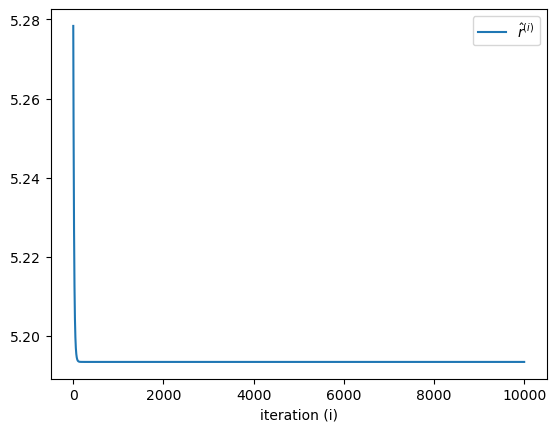

In [50]:
plt.plot(rhs, label=r"$\hat{r}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

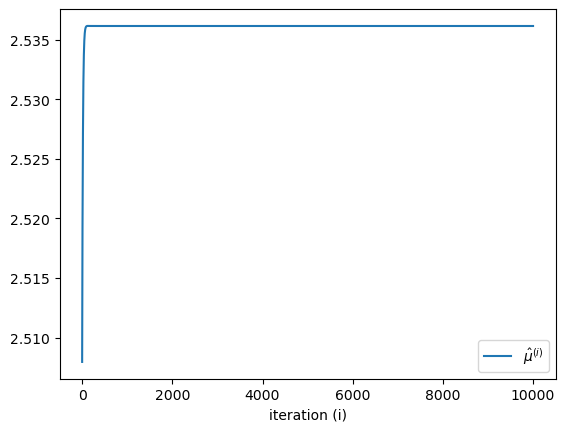

In [28]:
plt.plot(mhs_0, label=r"$\hat{\mu}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

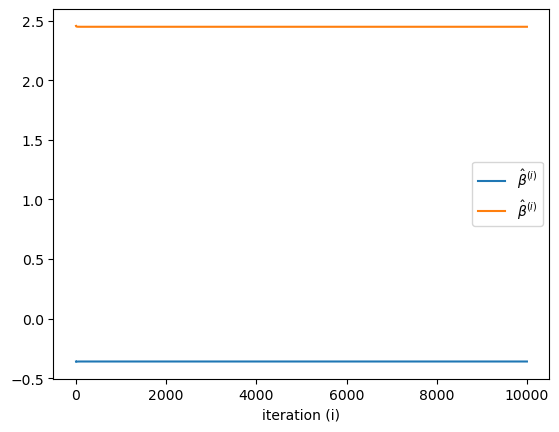

In [29]:
plt.plot(bhs, label=r"$\hat{\beta}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

# 4. Parametric bootstrap

In [21]:
num_sim = 1000
n_iter = 1000

## simulation

In [22]:
def NB(m, r):
    return np.random.negative_binomial(r, r/(m+r))

In [24]:
r = rmle
mu_0 = mmle_0
beta = bmle

In [25]:
R = np.zeros(T+T0)
for t in np.arange(T+T0):
    R[t] = K / (1 + np.exp(beta @ A[t]))

In [29]:
I_sim = np.zeros(T+T0)
I_sim[0] = mu_0
for t in np.arange(1, T0):
    I_sim[t] = R[t] * np.sum(np.flip(I_sim[:t])*g[:t])
for t in np.arange(T0,T+T0):
    I_sim[t] = R[t] * np.sum(np.flip(I_sim[:t])*g[:t])

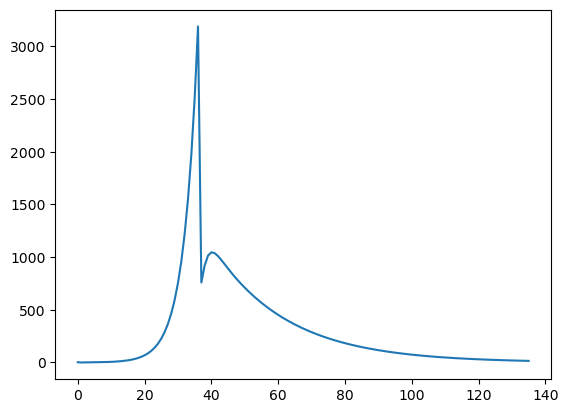

In [30]:
plt.plot(I_sim)

In [31]:
Y_sim = np.zeros([T])    
for t in np.arange(T):
    Y_sim[t] = NB(alpha * np.sum(np.flip(I_sim[:t+T0])*pi[:t+T0]), r)

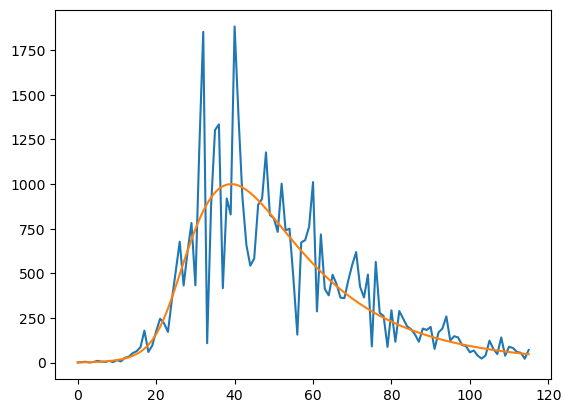

In [32]:
Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
plt.plot(Y_sim)
plt.plot(Pi@I_sim)

In [88]:
rhs, mhs_0, bhs =\
    fit(Y_data, r, mu_0, beta, 
        history=True, verbose=True, n_iter=n_iter, step_size=1)

Before EM, ll: -665.459450
1-th iteration finished, ll: -665.459450, lapse: 0.012sec.
2-th iteration finished, ll: -665.459450, lapse: 0.015sec.
3-th iteration finished, ll: -665.459450, lapse: 0.008sec.
4-th iteration finished, ll: -665.459450, lapse: 0.010sec.
5-th iteration finished, ll: -665.459450, lapse: 0.006sec.
6-th iteration finished, ll: -665.459450, lapse: 0.009sec.
7-th iteration finished, ll: -665.459450, lapse: 0.007sec.
8-th iteration finished, ll: -665.459450, lapse: 0.008sec.
9-th iteration finished, ll: -665.459450, lapse: 0.009sec.
10-th iteration finished, ll: -665.459450, lapse: 0.009sec.
11-th iteration finished, ll: -665.459450, lapse: 0.008sec.
12-th iteration finished, ll: -665.459450, lapse: 0.013sec.
13-th iteration finished, ll: -665.459450, lapse: 0.009sec.
14-th iteration finished, ll: -665.459450, lapse: 0.006sec.
15-th iteration finished, ll: -665.459450, lapse: 0.004sec.
16-th iteration finished, ll: -665.459450, lapse: 0.007sec.
17-th iteration finish

166-th iteration finished, ll: -665.459450, lapse: 0.014sec.
167-th iteration finished, ll: -665.459450, lapse: 0.012sec.
168-th iteration finished, ll: -665.459450, lapse: 0.005sec.
169-th iteration finished, ll: -665.459450, lapse: 0.005sec.
170-th iteration finished, ll: -665.459450, lapse: 0.005sec.
171-th iteration finished, ll: -665.459450, lapse: 0.010sec.
172-th iteration finished, ll: -665.459450, lapse: 0.005sec.
173-th iteration finished, ll: -665.459450, lapse: 0.006sec.
174-th iteration finished, ll: -665.459450, lapse: 0.006sec.
175-th iteration finished, ll: -665.459450, lapse: 0.005sec.
176-th iteration finished, ll: -665.459450, lapse: 0.005sec.
177-th iteration finished, ll: -665.459450, lapse: 0.008sec.
178-th iteration finished, ll: -665.459450, lapse: 0.006sec.
179-th iteration finished, ll: -665.459450, lapse: 0.006sec.
180-th iteration finished, ll: -665.459450, lapse: 0.009sec.
181-th iteration finished, ll: -665.459450, lapse: 0.013sec.
182-th iteration finishe

314-th iteration finished, ll: -665.459450, lapse: 0.007sec.
315-th iteration finished, ll: -665.459450, lapse: 0.022sec.
316-th iteration finished, ll: -665.459450, lapse: 0.005sec.
317-th iteration finished, ll: -665.459450, lapse: 0.005sec.
318-th iteration finished, ll: -665.459450, lapse: 0.023sec.
319-th iteration finished, ll: -665.459450, lapse: 0.015sec.
320-th iteration finished, ll: -665.459450, lapse: 0.017sec.
321-th iteration finished, ll: -665.459450, lapse: 0.021sec.
322-th iteration finished, ll: -665.459450, lapse: 0.008sec.
323-th iteration finished, ll: -665.459450, lapse: 0.005sec.
324-th iteration finished, ll: -665.459450, lapse: 0.006sec.
325-th iteration finished, ll: -665.459450, lapse: 0.005sec.
326-th iteration finished, ll: -665.459450, lapse: 0.004sec.
327-th iteration finished, ll: -665.459450, lapse: 0.004sec.
328-th iteration finished, ll: -665.459450, lapse: 0.006sec.
329-th iteration finished, ll: -665.459450, lapse: 0.006sec.
330-th iteration finishe

449-th iteration finished, ll: -665.459450, lapse: 0.011sec.
450-th iteration finished, ll: -665.459450, lapse: 0.009sec.
451-th iteration finished, ll: -665.459450, lapse: 0.012sec.
452-th iteration finished, ll: -665.459450, lapse: 0.013sec.
453-th iteration finished, ll: -665.459450, lapse: 0.006sec.
454-th iteration finished, ll: -665.459450, lapse: 0.005sec.
455-th iteration finished, ll: -665.459450, lapse: 0.009sec.
456-th iteration finished, ll: -665.459450, lapse: 0.010sec.
457-th iteration finished, ll: -665.459450, lapse: 0.009sec.
458-th iteration finished, ll: -665.459450, lapse: 0.007sec.
459-th iteration finished, ll: -665.459450, lapse: 0.007sec.
460-th iteration finished, ll: -665.459450, lapse: 0.011sec.
461-th iteration finished, ll: -665.459450, lapse: 0.005sec.
462-th iteration finished, ll: -665.459450, lapse: 0.005sec.
463-th iteration finished, ll: -665.459450, lapse: 0.008sec.
464-th iteration finished, ll: -665.459450, lapse: 0.010sec.
465-th iteration finishe

593-th iteration finished, ll: -665.459450, lapse: 0.006sec.
594-th iteration finished, ll: -665.459450, lapse: 0.013sec.
595-th iteration finished, ll: -665.459450, lapse: 0.005sec.
596-th iteration finished, ll: -665.459450, lapse: 0.007sec.
597-th iteration finished, ll: -665.459450, lapse: 0.005sec.
598-th iteration finished, ll: -665.459450, lapse: 0.005sec.
599-th iteration finished, ll: -665.459450, lapse: 0.007sec.
600-th iteration finished, ll: -665.459450, lapse: 0.011sec.
601-th iteration finished, ll: -665.459450, lapse: 0.005sec.
602-th iteration finished, ll: -665.459450, lapse: 0.007sec.
603-th iteration finished, ll: -665.459450, lapse: 0.007sec.
604-th iteration finished, ll: -665.459450, lapse: 0.007sec.
605-th iteration finished, ll: -665.459450, lapse: 0.007sec.
606-th iteration finished, ll: -665.459450, lapse: 0.005sec.
607-th iteration finished, ll: -665.459450, lapse: 0.007sec.
608-th iteration finished, ll: -665.459450, lapse: 0.010sec.
609-th iteration finishe

758-th iteration finished, ll: -665.459450, lapse: 0.010sec.
759-th iteration finished, ll: -665.459450, lapse: 0.007sec.
760-th iteration finished, ll: -665.459450, lapse: 0.017sec.
761-th iteration finished, ll: -665.459450, lapse: 0.007sec.
762-th iteration finished, ll: -665.459450, lapse: 0.009sec.
763-th iteration finished, ll: -665.459450, lapse: 0.005sec.
764-th iteration finished, ll: -665.459450, lapse: 0.005sec.
765-th iteration finished, ll: -665.459450, lapse: 0.007sec.
766-th iteration finished, ll: -665.459450, lapse: 0.008sec.
767-th iteration finished, ll: -665.459450, lapse: 0.008sec.
768-th iteration finished, ll: -665.459450, lapse: 0.005sec.
769-th iteration finished, ll: -665.459450, lapse: 0.005sec.
770-th iteration finished, ll: -665.459450, lapse: 0.008sec.
771-th iteration finished, ll: -665.459450, lapse: 0.011sec.
772-th iteration finished, ll: -665.459450, lapse: 0.007sec.
773-th iteration finished, ll: -665.459450, lapse: 0.006sec.
774-th iteration finishe

912-th iteration finished, ll: -665.459450, lapse: 0.008sec.
913-th iteration finished, ll: -665.459450, lapse: 0.020sec.
914-th iteration finished, ll: -665.459450, lapse: 0.010sec.
915-th iteration finished, ll: -665.459450, lapse: 0.006sec.
916-th iteration finished, ll: -665.459450, lapse: 0.008sec.
917-th iteration finished, ll: -665.459450, lapse: 0.007sec.
918-th iteration finished, ll: -665.459450, lapse: 0.009sec.
919-th iteration finished, ll: -665.459450, lapse: 0.009sec.
920-th iteration finished, ll: -665.459450, lapse: 0.005sec.
921-th iteration finished, ll: -665.459450, lapse: 0.005sec.
922-th iteration finished, ll: -665.459450, lapse: 0.004sec.
923-th iteration finished, ll: -665.459450, lapse: 0.004sec.
924-th iteration finished, ll: -665.459450, lapse: 0.006sec.
925-th iteration finished, ll: -665.459450, lapse: 0.010sec.
926-th iteration finished, ll: -665.459450, lapse: 0.008sec.
927-th iteration finished, ll: -665.459450, lapse: 0.005sec.
928-th iteration finishe

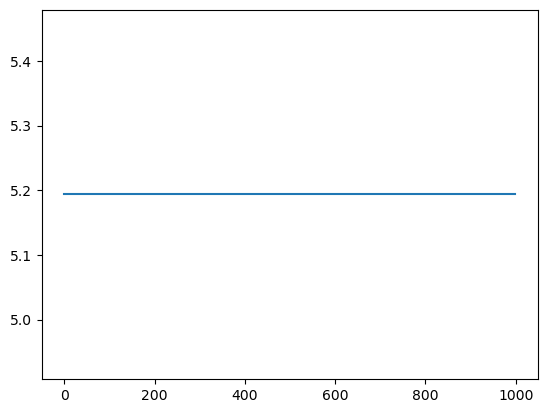

In [92]:
plt.plot(rhs)

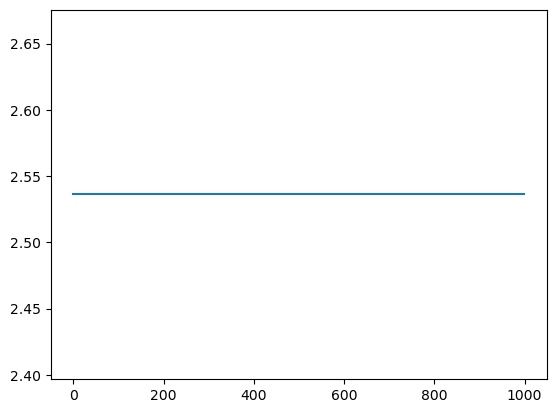

In [93]:
plt.plot(mhs_0)

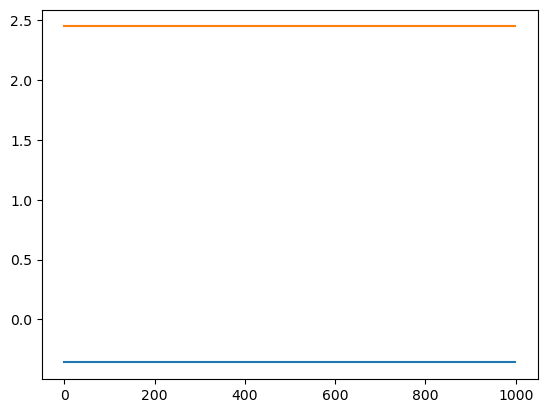

In [94]:
plt.plot(bhs)

## iteration

In [79]:
rsim = np.zeros([num_sim, n_iter])
msim_0 = np.zeros([num_sim, n_iter])
bsim = np.zeros([num_sim, n_iter, d])

In [80]:
Ys_sim = np.zeros([num_sim, T])

In [95]:
for iter_sim in np.arange(num_sim):
    start_sim = time.time()
    
    Y_sim = np.zeros([T])    
    for t in np.arange(T):
        Y_sim[t] = NB(alpha * np.sum(np.flip(I_sim[:t+T0])*pi[:t+T0]), r)
    
    rhat, mhat_0, bhat =\
        fit(Y_sim, rinit=r, minit_0 = mu_0, binit = beta,
            history=True, n_iter=n_iter, step_size=1) 
    
    msim_0[iter_sim] = mhat_0
    rsim[iter_sim] = rhat
    bsim[iter_sim] = bhat
    
    Ys_sim[iter_sim] = Y_sim
    
    sys.__stdout__.write("%d-th simulation finished, %f sec.\n"
                         %(iter_sim+1, time.time()-start_sim))
    sys.__stdout__.flush()

1-th simulation finished, 6.662324 sec.
2-th simulation finished, 6.632051 sec.
3-th simulation finished, 7.149840 sec.
4-th simulation finished, 6.984388 sec.
5-th simulation finished, 6.435731 sec.
6-th simulation finished, 6.382520 sec.
7-th simulation finished, 6.710486 sec.
8-th simulation finished, 6.648461 sec.
9-th simulation finished, 6.910719 sec.
10-th simulation finished, 6.461470 sec.
11-th simulation finished, 6.426956 sec.
12-th simulation finished, 6.634110 sec.
13-th simulation finished, 6.493098 sec.
14-th simulation finished, 6.620521 sec.
15-th simulation finished, 6.256007 sec.
16-th simulation finished, 6.870497 sec.
17-th simulation finished, 6.748463 sec.
18-th simulation finished, 6.496123 sec.
19-th simulation finished, 7.075479 sec.
20-th simulation finished, 6.297705 sec.
21-th simulation finished, 7.846723 sec.
22-th simulation finished, 6.726734 sec.
23-th simulation finished, 6.495189 sec.
24-th simulation finished, 6.735937 sec.
25-th simulation finished

199-th simulation finished, 8.520190 sec.
200-th simulation finished, 8.794251 sec.
201-th simulation finished, 8.756386 sec.
202-th simulation finished, 8.820878 sec.
203-th simulation finished, 8.269479 sec.
204-th simulation finished, 9.216962 sec.
205-th simulation finished, 8.635725 sec.
206-th simulation finished, 8.498059 sec.
207-th simulation finished, 8.323040 sec.
208-th simulation finished, 8.392748 sec.
209-th simulation finished, 8.444513 sec.
210-th simulation finished, 8.289816 sec.
211-th simulation finished, 8.125670 sec.
212-th simulation finished, 8.224881 sec.
213-th simulation finished, 8.303141 sec.
214-th simulation finished, 8.494168 sec.
215-th simulation finished, 8.359847 sec.
216-th simulation finished, 8.543211 sec.
217-th simulation finished, 8.400374 sec.
218-th simulation finished, 8.141486 sec.
219-th simulation finished, 8.816790 sec.
220-th simulation finished, 8.863235 sec.
221-th simulation finished, 8.208800 sec.
222-th simulation finished, 8.4444

394-th simulation finished, 8.744663 sec.
395-th simulation finished, 8.171548 sec.
396-th simulation finished, 8.132940 sec.
397-th simulation finished, 8.539135 sec.
398-th simulation finished, 10.921652 sec.
399-th simulation finished, 10.544916 sec.
400-th simulation finished, 8.654557 sec.
401-th simulation finished, 8.932122 sec.
402-th simulation finished, 9.077021 sec.
403-th simulation finished, 8.569928 sec.
404-th simulation finished, 9.759815 sec.
405-th simulation finished, 8.615639 sec.
406-th simulation finished, 8.564419 sec.
407-th simulation finished, 8.396945 sec.
408-th simulation finished, 7.772682 sec.
409-th simulation finished, 8.119740 sec.
410-th simulation finished, 8.125222 sec.
411-th simulation finished, 7.766215 sec.
412-th simulation finished, 7.974857 sec.
413-th simulation finished, 7.759586 sec.
414-th simulation finished, 8.152573 sec.
415-th simulation finished, 7.846237 sec.
416-th simulation finished, 7.559606 sec.
417-th simulation finished, 7.63

590-th simulation finished, 7.103074 sec.
591-th simulation finished, 7.271986 sec.
592-th simulation finished, 7.360858 sec.
593-th simulation finished, 7.182375 sec.
594-th simulation finished, 7.694081 sec.
595-th simulation finished, 9.059912 sec.
596-th simulation finished, 9.310869 sec.
597-th simulation finished, 7.891087 sec.
598-th simulation finished, 7.777961 sec.
599-th simulation finished, 7.714210 sec.
600-th simulation finished, 7.704256 sec.
601-th simulation finished, 7.474035 sec.
602-th simulation finished, 7.597659 sec.
603-th simulation finished, 7.561131 sec.
604-th simulation finished, 7.586562 sec.
605-th simulation finished, 7.714836 sec.
606-th simulation finished, 7.554677 sec.
607-th simulation finished, 7.074514 sec.
608-th simulation finished, 7.154423 sec.
609-th simulation finished, 7.433626 sec.
610-th simulation finished, 7.183838 sec.
611-th simulation finished, 7.340575 sec.
612-th simulation finished, 7.455885 sec.
613-th simulation finished, 7.3118

786-th simulation finished, 7.152399 sec.
787-th simulation finished, 7.591562 sec.
788-th simulation finished, 7.342856 sec.
789-th simulation finished, 7.176337 sec.
790-th simulation finished, 7.153606 sec.
791-th simulation finished, 7.176477 sec.
792-th simulation finished, 7.291041 sec.
793-th simulation finished, 9.461911 sec.
794-th simulation finished, 7.206110 sec.
795-th simulation finished, 7.143303 sec.
796-th simulation finished, 7.196695 sec.
797-th simulation finished, 7.277317 sec.
798-th simulation finished, 7.111564 sec.
799-th simulation finished, 7.455154 sec.
800-th simulation finished, 7.198249 sec.
801-th simulation finished, 7.278567 sec.
802-th simulation finished, 7.653457 sec.
803-th simulation finished, 7.357001 sec.
804-th simulation finished, 7.167317 sec.
805-th simulation finished, 7.106609 sec.
806-th simulation finished, 7.158294 sec.
807-th simulation finished, 7.265489 sec.
808-th simulation finished, 7.117672 sec.
809-th simulation finished, 7.3572

982-th simulation finished, 7.222112 sec.
983-th simulation finished, 7.251876 sec.
984-th simulation finished, 7.091755 sec.
985-th simulation finished, 7.099645 sec.
986-th simulation finished, 7.302471 sec.
987-th simulation finished, 7.285408 sec.
988-th simulation finished, 7.173707 sec.
989-th simulation finished, 7.475065 sec.
990-th simulation finished, 7.110781 sec.
991-th simulation finished, 7.529224 sec.
992-th simulation finished, 7.320227 sec.
993-th simulation finished, 7.848632 sec.
994-th simulation finished, 7.581296 sec.
995-th simulation finished, 7.200212 sec.
996-th simulation finished, 7.108194 sec.
997-th simulation finished, 7.056613 sec.
998-th simulation finished, 7.108332 sec.
999-th simulation finished, 7.070827 sec.
1000-th simulation finished, 7.125445 sec.


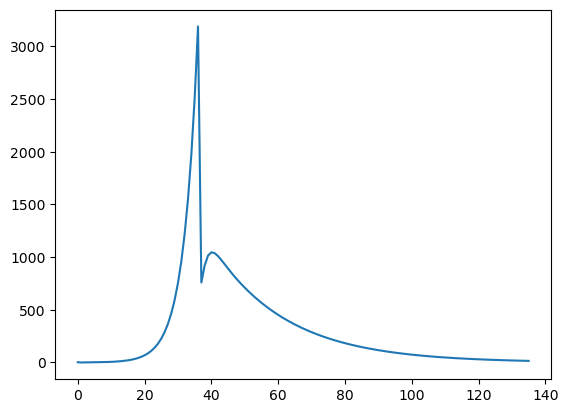

In [96]:
plt.plot(I_sim)

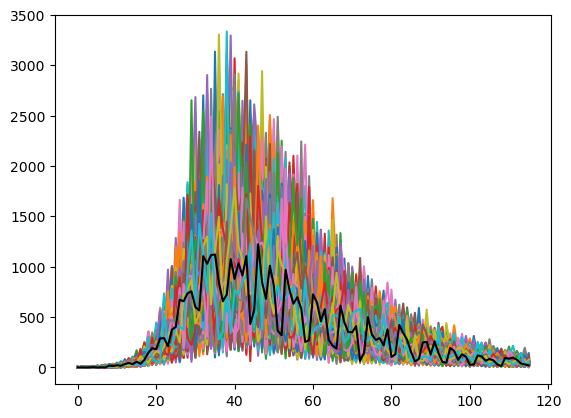

In [97]:
plt.plot(Ys_sim.T)
plt.plot(Y_data, color='black')
plt.show()

## plots

In [33]:
id_valid = (rsim[:,0] > 0)

(array([  5.,  67., 202., 288., 236., 112.,  59.,  23.,   7.,   1.]),
 array([3.28708119, 3.83691414, 4.38674708, 4.93658003, 5.48641298,
        6.03624593, 6.58607888, 7.13591183, 7.68574478, 8.23557772,
        8.78541067]),
 <BarContainer object of 10 artists>)

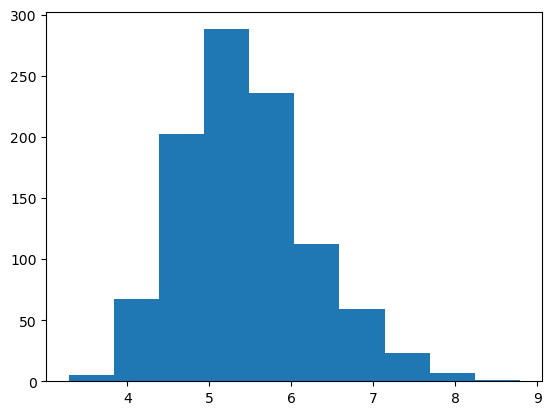

In [34]:
plt.hist(rsim[id_valid,-1])

(array([ 16., 126., 239., 276., 179.,  94.,  44.,  17.,   7.,   2.]),
 array([0.72079846, 1.24004682, 1.75929519, 2.27854355, 2.79779191,
        3.31704028, 3.83628864, 4.35553701, 4.87478537, 5.39403373,
        5.9132821 ]),
 <BarContainer object of 10 artists>)

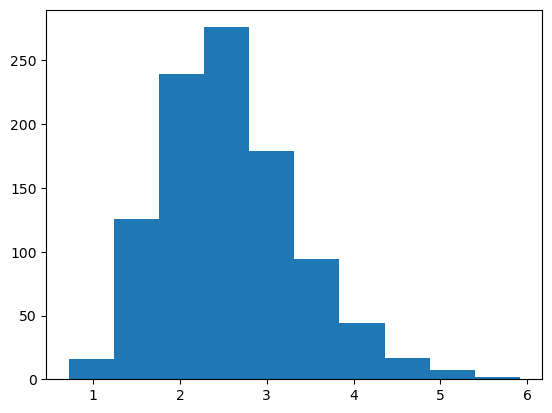

In [35]:
plt.hist(msim_0[id_valid,-1])

Text(0, 0.5, '$\\hat{\\beta}_1$')

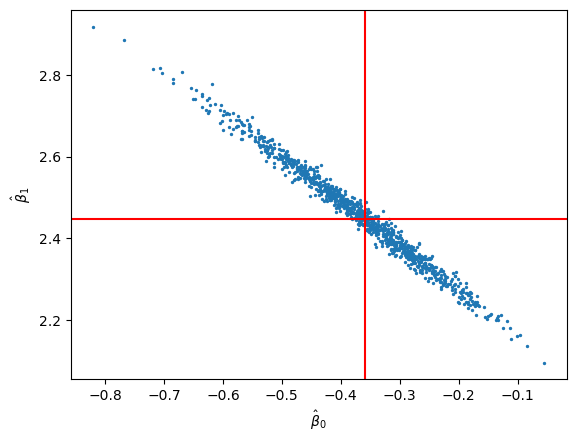

In [36]:
plt.scatter(bsim[id_valid,-1,0],bsim[id_valid,-1,1], s=2)
plt.axhline(y=beta[1], color='red')
plt.axvline(x=beta[0], color='red')
plt.xlabel(r"$\hat{\beta}_0$"); plt.ylabel(r"$\hat{\beta}_1$")

(array([  5.,  40., 121., 238., 264., 187.,  95.,  39.,   9.,   2.]),
 array([2.09542313, 2.17778729, 2.26015144, 2.3425156 , 2.42487976,
        2.50724391, 2.58960807, 2.67197222, 2.75433638, 2.83670053,
        2.91906469]),
 <BarContainer object of 10 artists>)

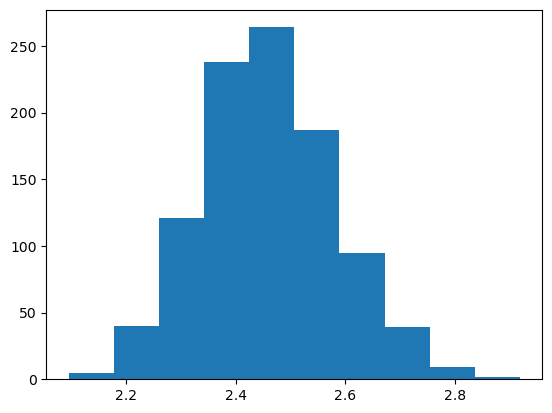

In [37]:
plt.hist(bsim[id_valid,-1,1])

In [38]:
np.sqrt(np.cov(bsim[id_valid,-1,:].T)[0,0])

0.11167391785395978

In [39]:
np.sqrt(np.cov(bsim[id_valid,-1,:].T)[1,1])

0.12213340913381593

In [40]:
np.cov(bsim[id_valid,-1,:].T)

array([[ 0.01247106, -0.01352542],
       [-0.01352542,  0.01491657]])

In [41]:
Rsim = np.zeros([T+T0,np.sum(id_valid)])
for t in np.arange(T+T0):
    Rsim[t] = K / (1 + np.exp(bsim[id_valid,-1,:] @ A[t]))

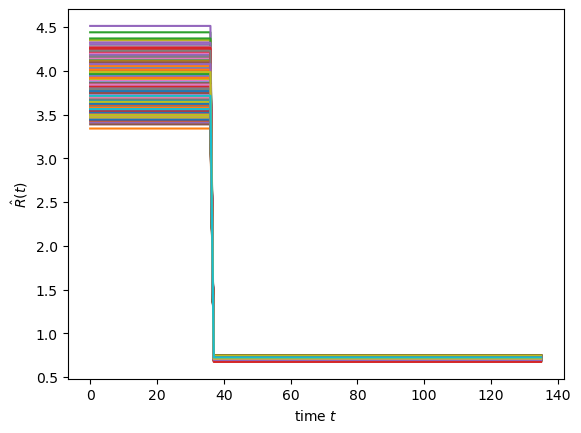

In [42]:
plt.plot(Rsim)
plt.xlabel(r"time $t$"); plt.ylabel(r"$\hat{R}(t)$")
plt.show()

# save and load

In [76]:
# np.savez("result_parametric_negative_binomial.npz",
#          mmle_0 = mmle_0, rmle = rmle, bmle = bmle,
#          mhs_0 = mhs_0, rhs = rhs, bhs = bhs,
#          msim_0 = msim_0, rsim = rsim, bsim = bsim,
#          Ys_sim = Ys_sim, pi = pi, g = g, A = A)

In [23]:
locals().update(np.load("result_parametric_negative_binomial.npz"))